Diabetes Test Using Decision Tree

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
!pip install jdc
import jdc
%matplotlib inline




In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Diabetes/

/content/drive/MyDrive/Diabetes


In [5]:
# Read data
diabetesdf = pd.read_csv('diabetes.csv')
print('Diabetes data shape: ', diabetesdf.shape)
diabetesdf.head()

Diabetes data shape:  (15000, 10)


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Since Patient Id has not any important information we can drop that column

In [6]:
diabetesdf=diabetesdf.drop("PatientID",axis=1)

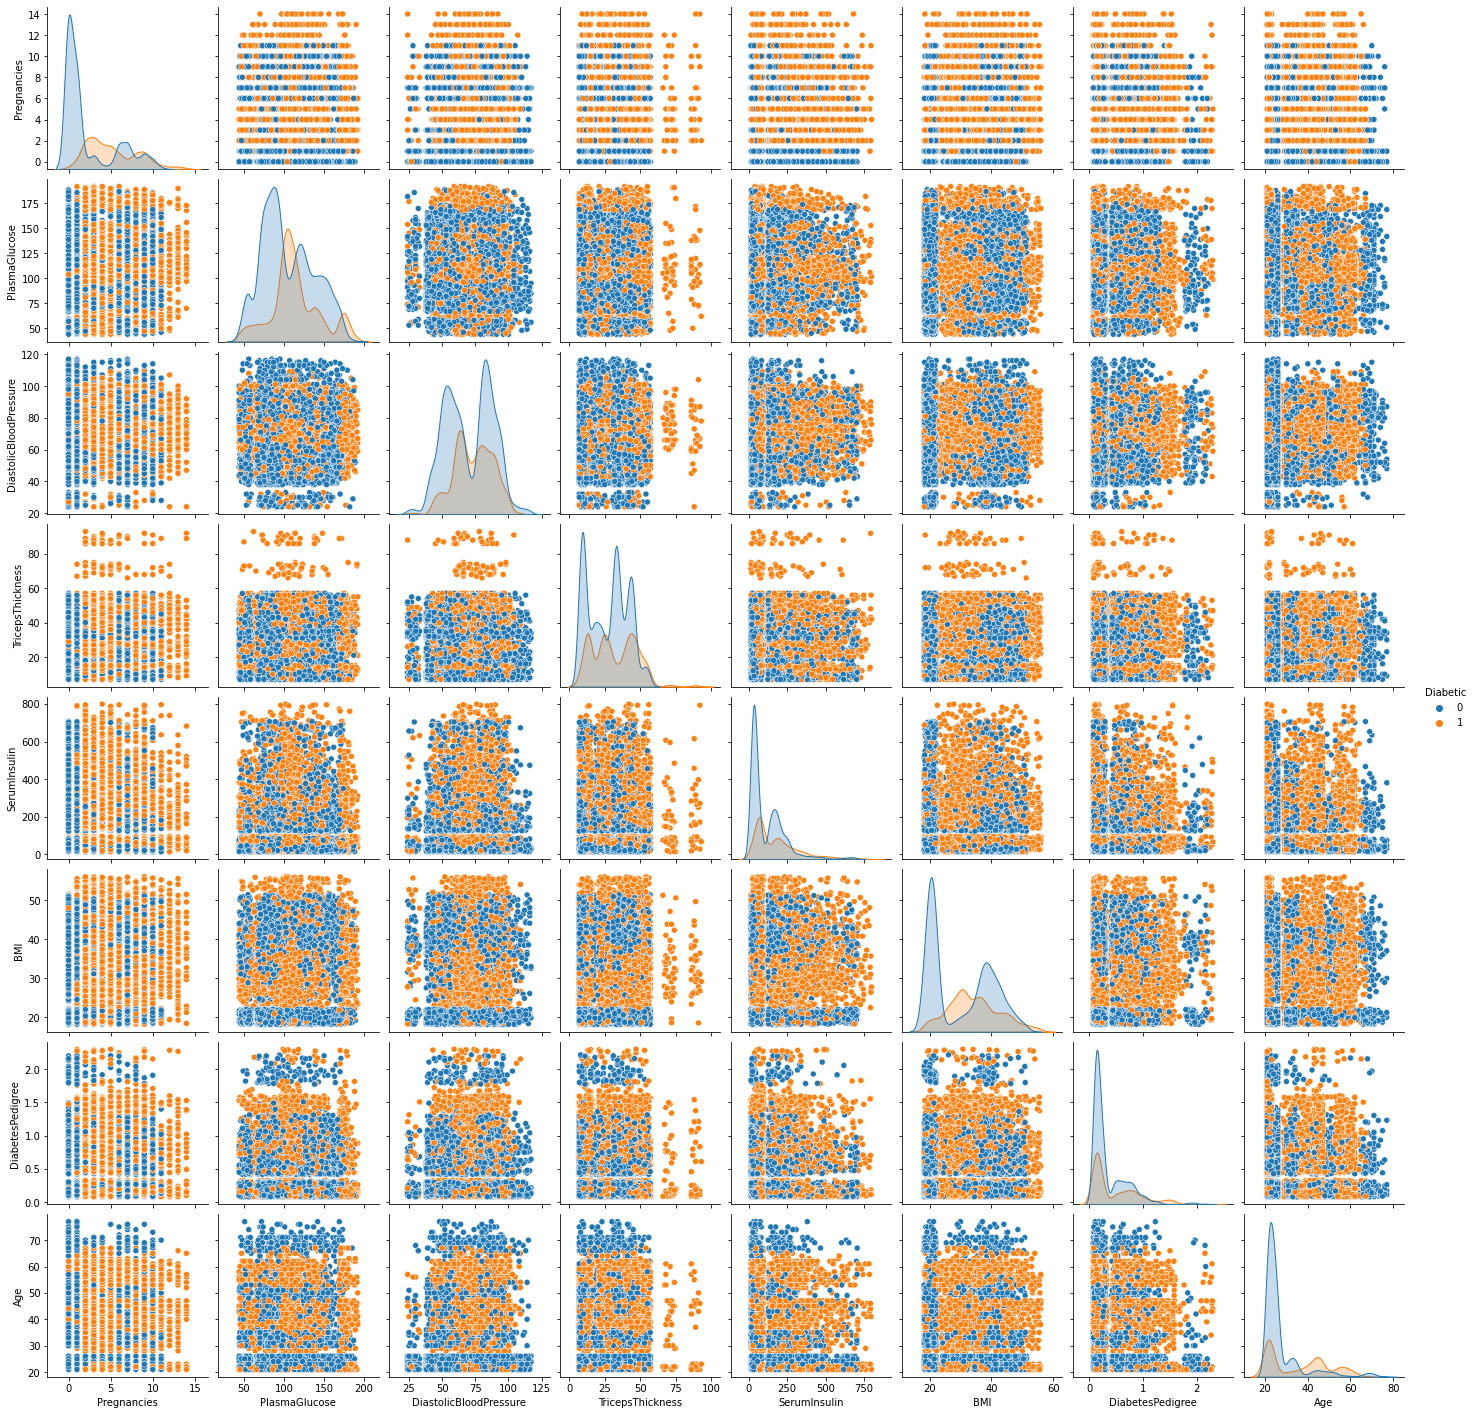

In [ ]:
#plot pair plot to visualise the attributes all at once
sns.pairplot(data=diabetesdf, hue = 'Diabetic')

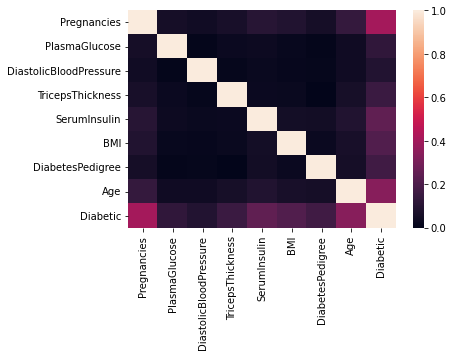

In [ ]:
# correlation matrix
sns.heatmap(diabetesdf.corr())

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for no diabetes, or a 1 indicating person is diabetic. We can first examine the number of person falling into each category.

In [7]:
diabetesdf['Diabetic'].value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

In [8]:
diabetesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pregnancies             15000 non-null  int64  
 1   PlasmaGlucose           15000 non-null  int64  
 2   DiastolicBloodPressure  15000 non-null  int64  
 3   TricepsThickness        15000 non-null  int64  
 4   SerumInsulin            15000 non-null  int64  
 5   BMI                     15000 non-null  float64
 6   DiabetesPedigree        15000 non-null  float64
 7   Age                     15000 non-null  int64  
 8   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.0 MB


Since all value are in numerical form there is no need of encoding

In [9]:
target = ['Diabetic']
X = diabetesdf.drop(target, axis=1)
Y = diabetesdf[target]

Seperating Test and Train Data

In [10]:
def TestTrain(df):
  trainData = df.sample(frac=0.9, random_state=25)
  testData = df.drop(trainData.index)

  # Export csv of train and test data
  trainData.to_csv( "trainData.csv", index=False, encoding='utf-8-sig')
  testData.to_csv( "testData.csv", index=False, encoding='utf-8-sig')

  return trainData, testData

In [11]:
trainX, testX = TestTrain(X)
trainY, testY = TestTrain(Y)
train_df,test_df = TestTrain(diabetesdf)

In [12]:
trainX = trainX.values
trainY = trainY.values.flatten()
testX = testX.values
testY = testY.values.flatten()

In [13]:
trainY

array([1, 1, 0, ..., 0, 0, 0])

In [14]:
def entropy(y):
    
    label_column = y
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [42]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None,gain=None, *, value=None,
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [16]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

    # select the best split according to information gain
        best_gain,best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right,best_gain)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return best_gain,split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def print_tree(self,Features):
      self.root.print_node(Features)

    def return_root(self):
      return self.root




In [17]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy



In [18]:
features = list(X.columns)
features

['Pregnancies',
 'PlasmaGlucose',
 'DiastolicBloodPressure',
 'TricepsThickness',
 'SerumInsulin',
 'BMI',
 'DiabetesPedigree',
 'Age']

In [26]:
clf = DecisionTree(max_depth=10)
decisionTree = clf.fit(trainX, trainY)
root = clf.return_root()


In [31]:
def printTree(node, level=0):
  if(node.is_leaf_node()):
      print(' ' * 2 * level + '|')
      print(' ' * 2 * level + '----> ',"Diabetic",node.value==1)
      print(' ' * 2 * level + '|')
  else:
      printTree(node.left, level + 1)
      print(' ' * 2 * level + '|')
      print(' ' * 2 * level + '----> ',features[node.feature],node.threshold)
      print(' ' * 2 * level + '|')
      printTree(node.right, level + 1)


In [39]:
printTree(root)

            |
            ---->  Diabetic False
            |
          |
          ---->  SerumInsulin 51.0
          |
                    |
                    ---->  Diabetic True
                    |
                  |
                  ---->  SerumInsulin 52.0
                  |
                    |
                    ---->  Diabetic False
                    |
                |
                ---->  Age 21.0
                |
                  |
                  ---->  Diabetic False
                  |
              |
              ---->  SerumInsulin 88.0
              |
                |
                ---->  Diabetic True
                |
            |
            ---->  SerumInsulin 93.0
            |
                |
                ---->  Diabetic False
                |
              |
              ---->  Age 30.0
              |
                  |
                  ---->  Diabetic False
                  |
                |
                ---->  TricepsThic

In [40]:
y_pred = clf.predict(testX)
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [41]:
acc = accuracy(testY, y_pred)

print("Accuracy:", acc)

Accuracy: 0.9166666666666666


Comparision: Using Sklearn

In [36]:
#for encoding
from sklearn.preprocessing import LabelEncoder
#for train test splitting
from sklearn.model_selection import train_test_split
#for decision tree object
from sklearn.tree import DecisionTreeClassifier
#for checking testing results
from sklearn.metrics import classification_report, confusion_matrix
#for visualizing tree 
from sklearn.tree import plot_tree
from sklearn import metrics 

In [37]:
clf2 = DecisionTreeClassifier(max_depth=10)

# Train Decision Tree Classifer
clf2 = clf2.fit(trainX,trainY)

#Predict the response for test dataset
y_pred = clf2.predict(testX)

In [38]:
print("Accuracy:",metrics.accuracy_score(testY, y_pred))

Accuracy: 0.9153333333333333
